# Example for RNNACE.

In [1]:
import sys
sys.path.append('..')

### Data preparation

In [2]:
import numpy as np

In [3]:
def generate_toy_dataset(n_samples, n_steps, n_features):
    y = np.random.binomial(n=1, p=0.5, size=(n_samples,))  # Bernoulli distribution of size 'n_samples'.
    x = np.random.normal(loc=0, scale=0.2, size=(n_samples, n_steps, n_features))
    x[np.where(y == 0), :5, :1] -= 10  # the first 5 time steps and the first feature causally affect the outcome.
    x[np.where(y == 1), :5, :1] += 10
    y = y.astype('float').reshape(-1, 1)
    return x, y

n_samples = 1000
n_steps = 10
n_features = 3
n_classes = 1

x, y = generate_toy_dataset(n_samples, n_steps, n_features)

### Fit a predictor.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
class Model(nn.Module):

    def __init__(self, n_features, n_outputs, hidden_size=128):
        super().__init__()
        self._rnn = nn.GRU(n_features, hidden_size, batch_first=True)
        self._output_layer = nn.Linear(hidden_size, n_outputs)

    def forward(self, x):
        _, hidden_states = self._rnn(x)
        outputs = self._output_layer(hidden_states.squeeze())
        return outputs

In [6]:
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
model = Model(n_features, n_classes)

In [7]:
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
for epoch in range(100):
    optimizer.zero_grad()
    y_hat = torch.sigmoid(model(x))
    loss = F.binary_cross_entropy_with_logits(y_hat, y)
    loss.backward()
    optimizer.step()
    print(epoch + 1, loss.item())

1 0.7303061485290527
2 0.7243808507919312
3 0.718414843082428
4 0.7121202349662781
5 0.7052456140518188
6 0.6975357532501221
7 0.6887246370315552
8 0.6785421371459961
9 0.6667448282241821
10 0.6531828045845032
11 0.6379138827323914
12 0.6213533878326416
13 0.6043647527694702
14 0.5881187915802002
15 0.5736453533172607
16 0.5613607168197632
17 0.5510467290878296
18 0.5422731637954712
19 0.534758448600769
20 0.5284194350242615
21 0.5232528448104858
22 0.5192169547080994
23 0.5161876678466797
24 0.5139800906181335
25 0.5123966336250305
26 0.5112631320953369
27 0.5104445815086365
28 0.5098443031311035
29 0.5093954205513
30 0.5090530514717102
31 0.5087867379188538
32 0.5085756778717041
33 0.5084056258201599
34 0.5082665085792542
35 0.5081512331962585
36 0.5080546140670776
37 0.5079725384712219
38 0.5079023838043213
39 0.5078417658805847
40 0.5077890157699585
41 0.5077427625656128
42 0.5077019929885864
43 0.507665753364563
44 0.5076335072517395
45 0.5076045393943787
46 0.5075784921646118
47 

### Get estimated causal effects.

In [8]:
import numpy as np
from causal.effect import RNNACE

In [9]:
x = x.detach().cpu().numpy()
rnnace = RNNACE(model, 'binary')
causal_effect = rnnace.predict(x, n_steps - 1, 0, 0, 0.1)  # get the causal effect of do(alpha=0.01 | x) on feature 0, class 0 and the last time step (zero index).
print(causal_effect)

141.68544623365275


In [10]:
causal_effects = []
for class_idx in range(n_classes):
    for feature_idx in range(n_features):
        # get causal effects over whole feature space.
        causal_effects.append([rnnace.predict(x, n_steps - 1, feature_idx, class_idx, alpha) for alpha in np.linspace(x[:, feature_idx].min(), x[:, feature_idx].max(), 1000)])
causal_effects = np.array(causal_effects)
causal_effects = causal_effects.reshape(n_classes, n_features, -1)
print(causal_effects.shape)

(1, 3, 1000)


### Visualization

In [11]:
import matplotlib.pyplot as plt
import numpy as np

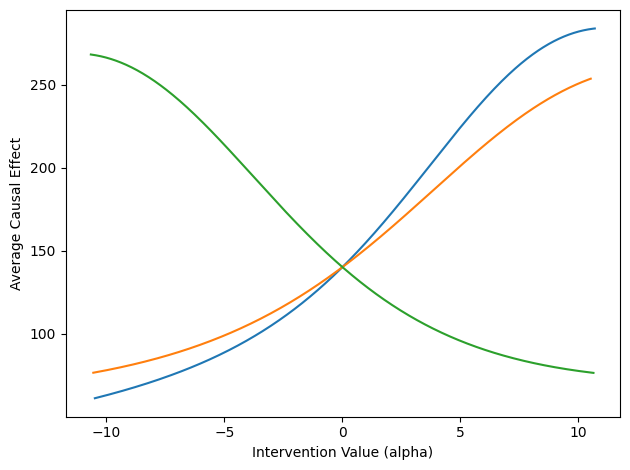

<Figure size 640x480 with 0 Axes>

In [12]:
for class_idx in range(n_classes):
    for feature_idx in range(n_features):
        a = np.linspace(x[:, feature_idx].min(), x[:, feature_idx].max(), 1000)
        b = causal_effects[class_idx, feature_idx]
        plt.plot(a, b)
    plt.xlabel('Intervention Value (alpha)')
    plt.ylabel('Average Causal Effect')
    plt.tight_layout()
    plt.show()
    plt.clf()